In [1]:
import numpy as np
from astropy.cosmology import WMAP9 as cosmo
import yt
import glob
import matplotlib.pyplot as plt

In [2]:
def parse_ionDens(numberDens,ionicFrac):
    # input numberDens=[nH, nHe]
    # input ionicFrac=[xHI, xHeI, xHeII]
    # return nHI,nHII,nHeI,nHeII,nHeIII,ne,ntot
    nHI=numberDens[0]*ionicFrac[0]
    nHII=numberDens[0]*(1-ionicFrac[0])
    nHeI=numberDens[1]*ionicFrac[1]
    nHeII=numberDens[1]*ionicFrac[2]
    nHeIII=numberDens[1]*(1-ionicFrac[1]-ionicFrac[2])
    ne=nHII+nHeII+2*nHeIII
    ntot=numberDens[0]+numberDens[1]+ne
    return nHI,nHII,nHeI,nHeII,nHeIII,ne,ntot


def sigma_HI_nu(nu):
    # atomic data: photo-ionization xsec of HI 
    # input nu in eV (> 13.6 eV!!! only works when nu>nuHI)
    # output sigma_HI in cm^2
    nuHI=13.6
    sigma_HI=6.30e-18*(1.34*(nu/nuHI)**-2.99-0.34*(nu/nuHI)**-3.99) #cm**2
    return sigma_HI

def sigma_HeI_nu(nu):
    # input nu in eV (> 24.6 eV!!!)
    nuHeI=24.6
    sigma_HI=7.03e-18*(1.66*(nu/nuHeI)**-2.05-0.66*(nu/nuHeI)**-3.05) #cm**2
    return sigma_HI

def sigma_HeII_nu(nu):
    # input nu in eV (> 54.4 eV!!!)
    nuHeII=54.4
    sigma_HI=1.50e-18*(1.34*(nu/nuHeII)**-2.99-0.34*(nu/nuHeII)**-3.99) #cm**2
    return sigma_HI

def ion_potential(species):
    ionpdict={'HI':13.6,'HeI':24.6,'HeII':54.4}
    return ionpdict[species]

def sigma_nu(nu,species):
    sigmadict={'HI':sigma_HI_nu,'HeI':sigma_HeI_nu,'HeII':sigma_HeII_nu}
    return sigmadict[species](nu)
    
def eGamma_HI(T):
    T5=T/1e5
    eGamma=1.17e-10*T**0.5*np.exp(-157809.1/T)/(1+T5**0.5)
    return eGamma

def eGamma_HeI(T):
    T5=T/1e5
    eGamma=4.76e-11*T**0.5*np.exp(-285335.4/T)/(1+T5**0.5)
    return eGamma

def eGamma_HeII(T):
    T5=T/1e5
    eGamma=1.14e-11*T**0.5*np.exp(-631515.0/T)/(1+T5**0.5)
    return eGamma

def colli_ioniz_rate(T,species):
    eGammaDict={'HI':eGamma_HI,'HeI':eGamma_HeI,'HeII':eGamma_HeII}
    return eGammaDict[species](T)

def alphaA_HI_Abel97(T):
    ### fit doesn't work for T>1e6K
    T_eV=T*8.61733e-5
    recHI=np.exp(-28.6130338 - 0.72411256*np.log(T_eV) - 2.02604473e-2*np.log(T_eV)**2
        - 2.38086188e-3*np.log(T_eV)**3 - 3.21260521e-4*np.log(T_eV)**4 - 1.42150291e-5*np.log(T_eV)**5
        + 4.98910892e-6*np.log(T_eV)**6 + 5.75561414e-7*np.log(T_eV)**7 - 1.85676704e-8*np.log(T_eV)**8
        - 3.07113524e-9*np.log(T_eV)**9)
    return recHI

def alpha_r_HeI_Abel97(T):
    ### radiative recombination, 10% error within 1e3-1e5 K, terrible outside
    T_eV=T*8.61733e-5
    return (3.925e-13*T_eV**-0.6353)
   
def alpha_d_HeI_Abel97(T):
    ### dielectronic recombination
    ### !!! more than a factor of 2 different above 1e5 K
    T_eV=T*8.61733e-5
    drecHeI=1.544e-9*T_eV**-1.5*np.exp(-48.596/T_eV)*(0.3+np.exp(8.1/T_eV))
    drecHeI[T<1e3]=0;
    return drecHeI

def alpha_HeI_Abel97(T):
    return (alpha_r_HeI_Abel97(T)+alpha_d_HeI_Abel97(T))

def alpha_HeII_Abel97(T):
    return (2*alphaA_HI_Abel97(T/4))

def recomb_rate(T,species):
    alphadict={'HI':alphaA_HI_Abel97,'HeI':alpha_HeI_Abel97,'HeII':alpha_HeII_Abel97, \
                "HeI_r":alpha_r_HeI_Abel97, "HeI_d":alpha_d_HeI_Abel97}
    return alphadict[species](T)

def init_photo_bkg(los):
    T=los["T"]
    nH=los["nH"]
    nHe=los["nHe"]
    xHI=los["xHI"]
    xHeI=los["xHeI"]
    xHeII=los["xHeII"]
    nHI,nHII,nHeI,nHeII,nHeIII,ne,ntot=parse_ionDens([nH,nHe],[xHI,xHeI,xHeII,T]) 
    Gamma_HI=recomb_rate(T,"HI")*(1-xHI)*ne/xHI-ne*eGamma_HI(T)
    Gamma_HeI=recomb_rate(T,"HeI")*(xHeII)*ne/xHeI-ne*eGamma_HeI(T)
    Gamma_HeII=recomb_rate(T,"HeII")*(1-xHeI-xHeII)*ne/xHeII-ne*eGamma_HeII(T)

    Gamma_HI[Gamma_HI<0]=0
    Gamma_HeI[Gamma_HeI<0]=0
    Gamma_HeII[Gamma_HeII<0]=0
    Heating_bkg=np.array([np.zeros_like(T),np.zeros_like(T),np.zeros_like(T)])
    return np.array([Gamma_HI,Gamma_HeI,Gamma_HeII]),Heating_bkg

In [3]:
rootpath="/data/hqchen/mfp_project/data/"
folder="F_a0.1452_50pMpc/"
zuni=1/0.1452-1
Hz=cosmo.H(zuni).value


In [5]:
gammalist=[]
dr=[]
losList=glob.glob(rootpath+folder+"lightray*h5")
for losName in losList[:]:
    lr=yt.load(losName)
    los={}
    los["T"]=lr.r['temperature'].in_units("K").v
    los["nH"]=((lr.r['gas','RT_HVAR_HI']+lr.r['gas','RT_HVAR_HII'])/yt.units.mp).in_units("cm**-3").v
    los["nHe"]=((lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])/yt.units.mp/4).in_units("cm**-3").v
    los["xHI"]=lr.r['gas','RT_HVAR_HI']/(lr.r['gas','RT_HVAR_HI']+lr.r['gas','RT_HVAR_HII'])
    los["xHeI"]=lr.r['gas','RT_HVAR_HeI']/(lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])
    los["xHeII"]=lr.r['gas','RT_HVAR_HeII']/(lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])
    gammalist+=list(init_photo_bkg(los)[0][0])
    dr+=list(lr.r['dl'].v)
#     plt.plot(init_photo_bkg(los)[0][0],alpha=0.1,c='b')
# # plt.yscale("log")
# plt.ylim(1e-13,2e-13)
# plt.grid()

yt : [INFO     ] 2024-02-06 15:53:41,190 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:53:41,190 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:53:41,191 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:53:41,192 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:53:41,193 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:53:41,194 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:53:41,194 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:53:41,195 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:53:41,196 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:53:41,196 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

/data/hqchen/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in multiply
yt : [INFO     ] 2024-02-06 15:53:44,262 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:53:44,263 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:53:44,263 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:53:44,264 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:53:44,265 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:53:44,265 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:53:44,266 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:53:44,267 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:53:44,267 Missing omega_radiation in par

yt : [INFO     ] 2024-02-06 15:53:47,244 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:53:47,245 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:53:47,245 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:53:47,246 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:53:47,247 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:53:47,247 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:53:47,248 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:53:47,248 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:53:47,249 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:53:47,249 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:53:50,294 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:53:50,295 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:53:50,296 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:53:50,296 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:53:50,297 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:53:50,297 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:53:50,298 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:53:50,298 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:53:50,304 Allocating for 5.663e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:53:50,311 Identified 3.937e+03 octs
yt : [INFO     ] 2024-02-06 15:53:5

yt : [INFO     ] 2024-02-06 15:53:53,378 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:53:53,378 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:53:53,379 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:53:53,380 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:53:53,381 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:53:53,381 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:53:53,391 Allocating for 6.972e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:53:53,399 Identified 4.793e+03 octs
yt : [INFO     ] 2024-02-06 15:53:53,807 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:53:53,808 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:53:53,809 Parameters: domain

yt : [INFO     ] 2024-02-06 15:53:56,486 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:53:56,487 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:53:56,488 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:53:56,489 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:53:56,498 Allocating for 6.897e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:53:56,506 Identified 4.569e+03 octs
yt : [INFO     ] 2024-02-06 15:53:57,009 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:53:57,009 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:53:57,010 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:53:57,011 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:53:59,632 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:53:59,632 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:53:59,642 Allocating for 6.932e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:53:59,650 Identified 4.841e+03 octs
yt : [INFO     ] 2024-02-06 15:54:00,054 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:00,055 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:00,056 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:00,057 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:54:00,058 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:00,059 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:00,059 Para

yt : [INFO     ] 2024-02-06 15:54:02,790 Allocating for 6.702e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:02,797 Identified 4.457e+03 octs
yt : [INFO     ] 2024-02-06 15:54:03,196 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:03,197 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:03,198 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:03,199 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:54:03,200 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:03,201 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:03,202 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:03,203 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:03,203

yt : [INFO     ] 2024-02-06 15:54:06,362 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:06,363 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:06,363 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:06,365 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:54:06,366 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:06,366 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:06,367 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:06,368 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:06,369 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:06,369 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:54:09,456 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:09,456 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:54:09,457 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:09,458 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:09,459 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:09,460 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:09,460 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:09,461 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:54:09,467 Allocating for 6.395e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:09,474 Identified 4.305e+03 octs
yt : [INFO     ] 2024-02-06 15:54:0

yt : [INFO     ] 2024-02-06 15:54:12,430 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:12,431 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:12,431 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:12,432 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:12,432 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:12,433 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:54:12,439 Allocating for 7.402e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:12,446 Identified 5.017e+03 octs
yt : [INFO     ] 2024-02-06 15:54:12,941 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:12,942 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:12,942 Parameters: domain

yt : [INFO     ] 2024-02-06 15:54:15,669 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:15,669 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:15,670 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:15,670 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:54:15,676 Allocating for 8.078e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:15,684 Identified 5.489e+03 octs
yt : [INFO     ] 2024-02-06 15:54:16,118 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:16,119 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:16,120 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:16,120 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:54:18,882 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:18,882 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:54:18,892 Allocating for 7.381e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:18,900 Identified 5.105e+03 octs
yt : [INFO     ] 2024-02-06 15:54:19,304 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:19,305 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:19,306 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:19,308 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:54:19,309 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:19,310 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:19,311 Para

yt : [INFO     ] 2024-02-06 15:54:21,901 Allocating for 7.808e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:21,910 Identified 5.193e+03 octs
yt : [INFO     ] 2024-02-06 15:54:22,412 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:22,413 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:22,414 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:22,415 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:54:22,416 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:22,417 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:22,417 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:22,418 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:22,419

yt : [INFO     ] 2024-02-06 15:54:25,337 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:25,337 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:25,338 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:25,339 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:54:25,339 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:25,340 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:25,341 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:25,341 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:25,342 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:25,342 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:54:28,777 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:28,778 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:54:28,779 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:28,779 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:28,780 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:28,780 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:28,781 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:28,782 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:54:28,788 Allocating for 6.697e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:28,795 Identified 4.521e+03 octs
yt : [INFO     ] 2024-02-06 15:54:2

yt : [INFO     ] 2024-02-06 15:54:31,921 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:31,922 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:31,922 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:31,923 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:31,924 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:31,925 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:54:31,934 Allocating for 6.276e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:31,942 Identified 4.297e+03 octs
yt : [INFO     ] 2024-02-06 15:54:32,341 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:32,342 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:32,343 Parameters: domain

yt : [INFO     ] 2024-02-06 15:54:35,005 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:35,006 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:35,006 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:35,007 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:54:35,017 Allocating for 5.452e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:35,024 Identified 3.761e+03 octs
yt : [INFO     ] 2024-02-06 15:54:35,433 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:35,434 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:35,435 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:35,436 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:54:38,236 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:38,237 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:54:38,243 Allocating for 7.418e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:38,250 Identified 5.057e+03 octs
yt : [INFO     ] 2024-02-06 15:54:38,654 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:38,654 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:38,655 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:38,656 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:54:38,657 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:38,657 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:38,658 Para

yt : [INFO     ] 2024-02-06 15:54:41,234 Allocating for 7.054e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:41,241 Identified 4.913e+03 octs
yt : [INFO     ] 2024-02-06 15:54:41,737 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:41,737 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:41,738 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:41,739 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:54:41,740 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:41,740 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:41,741 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:41,741 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:41,742

yt : [INFO     ] 2024-02-06 15:54:44,974 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:44,975 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:44,975 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:44,976 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:54:44,977 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:44,978 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:44,978 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:44,979 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:44,979 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:44,980 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:54:48,377 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:48,378 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:54:48,378 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:48,379 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:48,380 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:48,380 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:48,381 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:48,382 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:54:48,389 Allocating for 7.673e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:48,396 Identified 5.201e+03 octs
yt : [INFO     ] 2024-02-06 15:54:4

yt : [INFO     ] 2024-02-06 15:54:51,379 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:51,380 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:51,380 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:51,381 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:51,382 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:51,382 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:54:51,389 Allocating for 6.835e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:51,396 Identified 4.433e+03 octs
yt : [INFO     ] 2024-02-06 15:54:51,793 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:51,794 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:51,795 Parameters: domain

yt : [INFO     ] 2024-02-06 15:54:54,955 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:54:54,956 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:54:54,956 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:54,957 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:54:54,964 Allocating for 7.901e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:54,971 Identified 5.257e+03 octs
yt : [INFO     ] 2024-02-06 15:54:55,364 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:55,365 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:55,366 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:55,367 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:54:58,084 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:54:58,085 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:54:58,092 Allocating for 6.599e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:54:58,099 Identified 4.489e+03 octs
yt : [INFO     ] 2024-02-06 15:54:58,666 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:54:58,667 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:54:58,668 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:54:58,669 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:54:58,670 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:54:58,670 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:54:58,671 Para

yt : [INFO     ] 2024-02-06 15:55:01,289 Allocating for 7.206e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:01,295 Identified 4.457e+03 octs
yt : [INFO     ] 2024-02-06 15:55:01,699 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:01,699 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:01,700 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:01,701 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:55:01,702 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:01,703 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:01,703 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:01,704 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:01,705

yt : [INFO     ] 2024-02-06 15:55:04,918 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:04,919 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:04,920 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:04,921 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:55:04,921 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:04,922 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:04,923 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:04,923 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:04,924 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:04,925 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:55:07,984 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:07,985 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:55:07,986 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:07,986 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:07,987 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:07,988 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:07,988 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:07,989 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:55:07,997 Allocating for 7.678e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:08,005 Identified 5.113e+03 octs
yt : [INFO     ] 2024-02-06 15:55:0

yt : [INFO     ] 2024-02-06 15:55:11,135 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:11,135 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:11,136 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:11,136 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:11,137 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:11,137 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:55:11,144 Allocating for 6.345e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:11,150 Identified 4.249e+03 octs
yt : [INFO     ] 2024-02-06 15:55:11,529 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:11,530 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:11,531 Parameters: domain

yt : [INFO     ] 2024-02-06 15:55:14,108 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:14,108 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:14,109 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:14,110 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:55:14,116 Allocating for 7.345e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:14,123 Identified 5.033e+03 octs
yt : [INFO     ] 2024-02-06 15:55:14,631 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:14,632 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:14,632 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:14,633 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:55:17,211 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:17,211 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:55:17,217 Allocating for 6.263e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:17,224 Identified 4.401e+03 octs
yt : [INFO     ] 2024-02-06 15:55:17,613 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:17,614 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:17,614 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:17,615 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:55:17,616 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:17,616 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:17,617 Para

yt : [INFO     ] 2024-02-06 15:55:20,317 Allocating for 6.998e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:20,323 Identified 4.689e+03 octs
yt : [INFO     ] 2024-02-06 15:55:20,716 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:20,716 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:20,717 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:20,718 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:55:20,719 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:20,719 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:20,720 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:20,720 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:20,721

yt : [INFO     ] 2024-02-06 15:55:23,870 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:23,871 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:23,872 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:23,873 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:55:23,874 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:23,874 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:23,875 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:23,876 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:23,876 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:23,877 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:55:26,909 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:26,910 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:55:26,911 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:26,911 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:26,912 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:26,913 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:26,913 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:26,914 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:55:26,921 Allocating for 6.364e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:26,927 Identified 4.209e+03 octs
yt : [INFO     ] 2024-02-06 15:55:2

yt : [INFO     ] 2024-02-06 15:55:30,081 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:30,082 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:30,083 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:30,083 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:30,084 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:30,085 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:55:30,091 Allocating for 6.236e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:30,098 Identified 4.225e+03 octs
yt : [INFO     ] 2024-02-06 15:55:30,477 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:30,478 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:30,479 Parameters: domain

yt : [INFO     ] 2024-02-06 15:55:33,082 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:33,082 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:33,083 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:33,084 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:55:33,090 Allocating for 6.638e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:33,097 Identified 4.393e+03 octs
yt : [INFO     ] 2024-02-06 15:55:33,628 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:33,629 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:33,630 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:33,631 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:55:36,357 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:36,357 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:55:36,364 Allocating for 7.077e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:36,371 Identified 4.777e+03 octs
yt : [INFO     ] 2024-02-06 15:55:36,764 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:36,765 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:36,766 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:36,767 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:55:36,768 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:36,768 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:36,769 Para

yt : [INFO     ] 2024-02-06 15:55:39,389 Allocating for 7.033e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:39,396 Identified 4.657e+03 octs
yt : [INFO     ] 2024-02-06 15:55:39,789 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:39,790 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:39,791 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:39,792 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:55:39,793 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:39,793 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:39,794 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:39,795 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:39,795

yt : [INFO     ] 2024-02-06 15:55:42,987 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:42,988 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:42,989 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:42,989 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:55:42,990 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:42,991 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:42,992 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:42,992 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:42,993 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:42,994 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:55:46,093 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:46,094 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:55:46,095 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:46,096 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:46,097 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:46,097 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:46,098 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:46,099 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:55:46,105 Allocating for 7.282e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:46,112 Identified 4.961e+03 octs
yt : [INFO     ] 2024-02-06 15:55:4

yt : [INFO     ] 2024-02-06 15:55:49,361 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:49,362 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:49,363 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:49,363 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:49,364 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:49,365 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:55:49,371 Allocating for 6.670e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:49,378 Identified 4.505e+03 octs
yt : [INFO     ] 2024-02-06 15:55:49,767 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:49,768 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:49,769 Parameters: domain

yt : [INFO     ] 2024-02-06 15:55:52,479 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:52,480 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:52,480 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:52,481 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:55:52,487 Allocating for 6.916e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:52,494 Identified 4.545e+03 octs
yt : [INFO     ] 2024-02-06 15:55:52,880 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:52,881 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:52,881 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:52,882 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:55:56,114 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:55:56,114 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:55:56,121 Allocating for 7.550e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:56,129 Identified 5.257e+03 octs
yt : [INFO     ] 2024-02-06 15:55:56,523 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:56,524 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:56,525 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:56,526 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:55:56,527 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:56,527 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:56,528 Para

yt : [INFO     ] 2024-02-06 15:55:59,217 Allocating for 7.547e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:55:59,224 Identified 4.841e+03 octs
yt : [INFO     ] 2024-02-06 15:55:59,637 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:55:59,638 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:55:59,639 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:55:59,640 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:55:59,641 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:55:59,641 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:55:59,642 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:55:59,643 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:55:59,643

yt : [INFO     ] 2024-02-06 15:56:03,096 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:56:03,098 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:56:03,099 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:56:03,100 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:56:03,101 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:56:03,101 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:56:03,102 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:56:03,103 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:56:03,103 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:03,104 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:56:06,382 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:56:06,383 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:56:06,384 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:56:06,385 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:56:06,386 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:56:06,386 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:56:06,387 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:06,388 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:56:06,395 Allocating for 6.691e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:56:06,402 Identified 4.233e+03 octs
yt : [INFO     ] 2024-02-06 15:56:0

yt : [INFO     ] 2024-02-06 15:56:09,718 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:56:09,718 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:56:09,719 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:56:09,720 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:56:09,720 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:09,721 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:56:09,728 Allocating for 7.006e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:56:09,734 Identified 4.801e+03 octs
yt : [INFO     ] 2024-02-06 15:56:10,438 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:56:10,439 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:56:10,440 Parameters: domain

yt : [INFO     ] 2024-02-06 15:56:13,348 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:56:13,348 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:56:13,349 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:13,350 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:56:13,356 Allocating for 7.232e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:56:13,364 Identified 4.761e+03 octs
yt : [INFO     ] 2024-02-06 15:56:13,767 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:56:13,768 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:56:13,769 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:56:13,770 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:56:16,693 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:16,693 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:56:16,700 Allocating for 6.928e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:56:16,707 Identified 4.593e+03 octs
yt : [INFO     ] 2024-02-06 15:56:17,111 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:56:17,112 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:56:17,113 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:56:17,114 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:56:17,114 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:56:17,115 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:56:17,115 Para

yt : [INFO     ] 2024-02-06 15:56:20,285 Allocating for 7.789e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:56:20,293 Identified 5.217e+03 octs
yt : [INFO     ] 2024-02-06 15:56:20,694 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:56:20,694 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:56:20,695 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:56:20,696 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:56:20,696 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:56:20,697 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:56:20,697 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:56:20,698 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:56:20,698

yt : [INFO     ] 2024-02-06 15:56:23,982 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:56:23,983 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:56:23,984 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:56:23,985 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:56:23,985 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:56:23,986 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:56:23,986 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:56:23,987 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:56:23,987 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:23,987 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:56:27,712 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:56:27,712 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:56:27,713 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:56:27,714 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:56:27,714 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:56:27,715 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:56:27,715 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:27,716 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:56:27,723 Allocating for 6.772e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:56:27,730 Identified 4.497e+03 octs
yt : [INFO     ] 2024-02-06 15:56:2

yt : [INFO     ] 2024-02-06 15:56:31,123 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:56:31,124 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:56:31,124 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:56:31,125 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:56:31,126 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:31,127 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:56:31,137 Allocating for 6.719e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:56:31,146 Identified 4.201e+03 octs
yt : [INFO     ] 2024-02-06 15:56:31,555 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:56:31,557 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:56:31,558 Parameters: domain

yt : [INFO     ] 2024-02-06 15:56:34,470 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:56:34,471 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:56:34,471 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:34,472 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:56:34,479 Allocating for 7.812e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:56:34,487 Identified 5.497e+03 octs
yt : [INFO     ] 2024-02-06 15:56:34,980 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:56:34,981 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:56:34,982 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:56:34,983 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:56:38,230 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:38,231 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:56:38,237 Allocating for 6.551e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:56:38,244 Identified 4.441e+03 octs
yt : [INFO     ] 2024-02-06 15:56:38,652 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:56:38,653 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:56:38,654 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:56:38,655 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:56:38,656 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:56:38,657 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:56:38,657 Para

yt : [INFO     ] 2024-02-06 15:56:41,513 Allocating for 6.774e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:56:41,521 Identified 4.473e+03 octs
yt : [INFO     ] 2024-02-06 15:56:41,913 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:56:41,914 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:56:41,915 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:56:41,916 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:56:41,917 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:56:41,918 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:56:41,918 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:56:41,919 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:56:41,920

yt : [INFO     ] 2024-02-06 15:56:45,351 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:56:45,352 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:56:45,353 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:56:45,354 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:56:45,355 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:56:45,356 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:56:45,356 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:56:45,357 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:56:45,358 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:45,358 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:56:48,932 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:56:48,933 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:56:48,933 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:56:48,934 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:56:48,934 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:56:48,935 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:56:48,935 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:48,935 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:56:48,942 Allocating for 6.512e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:56:48,950 Identified 4.369e+03 octs
yt : [INFO     ] 2024-02-06 15:56:4

yt : [INFO     ] 2024-02-06 15:56:52,173 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:56:52,174 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:56:52,174 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:56:52,175 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:56:52,176 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:52,177 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:56:52,186 Allocating for 7.422e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:56:52,194 Identified 5.145e+03 octs
yt : [INFO     ] 2024-02-06 15:56:52,598 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:56:52,599 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:56:52,600 Parameters: domain

yt : [INFO     ] 2024-02-06 15:56:55,805 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:56:55,805 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:56:55,806 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:55,807 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:56:55,814 Allocating for 7.928e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:56:55,821 Identified 5.161e+03 octs
yt : [INFO     ] 2024-02-06 15:56:56,220 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:56:56,221 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:56:56,222 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:56:56,223 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:56:59,260 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:56:59,260 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:56:59,268 Allocating for 7.248e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:56:59,275 Identified 4.841e+03 octs
yt : [INFO     ] 2024-02-06 15:56:59,671 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:56:59,672 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:56:59,673 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:56:59,673 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:56:59,674 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:56:59,675 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:56:59,676 Para

yt : [INFO     ] 2024-02-06 15:57:02,637 Allocating for 8.207e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:57:02,649 Identified 5.697e+03 octs
yt : [INFO     ] 2024-02-06 15:57:03,164 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:57:03,165 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:57:03,166 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:57:03,167 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:57:03,168 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:57:03,169 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:57:03,169 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:03,170 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:03,171

yt : [INFO     ] 2024-02-06 15:57:06,361 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:57:06,362 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:57:06,363 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:57:06,364 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:57:06,365 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:57:06,366 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:57:06,366 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:06,367 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:06,368 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:57:06,368 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:57:09,881 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:57:09,882 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:57:09,883 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:57:09,883 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:57:09,884 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:09,885 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:09,885 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:57:09,886 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:57:09,894 Allocating for 6.423e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:57:09,901 Identified 4.337e+03 octs
yt : [INFO     ] 2024-02-06 15:57:1

yt : [INFO     ] 2024-02-06 15:57:13,165 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:57:13,166 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:57:13,166 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:13,167 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:13,168 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:57:13,168 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:57:13,175 Allocating for 7.726e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:57:13,182 Identified 5.345e+03 octs
yt : [INFO     ] 2024-02-06 15:57:13,579 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:57:13,579 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:57:13,580 Parameters: domain

yt : [INFO     ] 2024-02-06 15:57:16,435 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:16,436 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:16,436 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:57:16,437 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:57:16,444 Allocating for 6.729e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:57:16,450 Identified 4.553e+03 octs
yt : [INFO     ] 2024-02-06 15:57:16,851 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:57:16,852 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:57:16,853 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:57:16,855 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:57:19,997 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:57:19,997 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:57:20,008 Allocating for 7.355e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:57:20,017 Identified 4.753e+03 octs
yt : [INFO     ] 2024-02-06 15:57:20,432 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:57:20,433 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:57:20,434 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:57:20,435 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:57:20,436 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:57:20,437 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:57:20,438 Para

yt : [INFO     ] 2024-02-06 15:57:23,374 Allocating for 6.802e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:57:23,381 Identified 4.737e+03 octs
yt : [INFO     ] 2024-02-06 15:57:23,791 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:57:23,791 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:57:23,792 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:57:23,793 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:57:23,794 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:57:23,795 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:57:23,796 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:23,796 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:23,797

yt : [INFO     ] 2024-02-06 15:57:27,134 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:57:27,135 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:57:27,136 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:57:27,137 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:57:27,138 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:57:27,138 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:57:27,139 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:27,140 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:27,140 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:57:27,141 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:57:30,356 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:57:30,357 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:57:30,357 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:57:30,358 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:57:30,359 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:30,360 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:30,360 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:57:30,361 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:57:30,367 Allocating for 7.041e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:57:30,374 Identified 4.737e+03 octs
yt : [INFO     ] 2024-02-06 15:57:3

yt : [INFO     ] 2024-02-06 15:57:34,035 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:57:34,035 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:57:34,036 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:34,037 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:34,037 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:57:34,038 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:57:34,045 Allocating for 5.849e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:57:34,052 Identified 4.009e+03 octs
yt : [INFO     ] 2024-02-06 15:57:34,456 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:57:34,458 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:57:34,459 Parameters: domain

yt : [INFO     ] 2024-02-06 15:57:37,669 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:37,669 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:37,670 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:57:37,671 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:57:37,678 Allocating for 7.038e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:57:37,686 Identified 4.593e+03 octs
yt : [INFO     ] 2024-02-06 15:57:38,107 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:57:38,108 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:57:38,109 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:57:38,110 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:57:41,115 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:57:41,116 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:57:41,123 Allocating for 5.167e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:57:41,129 Identified 3.513e+03 octs
yt : [INFO     ] 2024-02-06 15:57:41,538 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:57:41,539 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:57:41,540 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:57:41,541 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:57:41,542 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:57:41,542 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:57:41,543 Para

yt : [INFO     ] 2024-02-06 15:57:44,552 Allocating for 6.949e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:57:44,559 Identified 4.665e+03 octs
yt : [INFO     ] 2024-02-06 15:57:45,365 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:57:45,366 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:57:45,367 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:57:45,368 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:57:45,369 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:57:45,369 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:57:45,370 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:45,371 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:45,371

yt : [INFO     ] 2024-02-06 15:57:48,902 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:57:48,903 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:57:48,904 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:57:48,905 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:57:48,906 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:57:48,906 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:57:48,907 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:48,908 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:48,908 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:57:48,909 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:57:52,343 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:57:52,344 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:57:52,345 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:57:52,346 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:57:52,347 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:52,348 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:52,348 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:57:52,349 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:57:52,356 Allocating for 7.005e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:57:52,363 Identified 4.593e+03 octs
yt : [INFO     ] 2024-02-06 15:57:5

yt : [INFO     ] 2024-02-06 15:57:55,797 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:57:55,797 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:57:55,798 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:55,799 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:55,799 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:57:55,800 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:57:55,807 Allocating for 6.419e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:57:55,814 Identified 4.393e+03 octs
yt : [INFO     ] 2024-02-06 15:57:56,215 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:57:56,216 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:57:56,217 Parameters: domain

yt : [INFO     ] 2024-02-06 15:57:59,251 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:57:59,251 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:57:59,252 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:57:59,253 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:57:59,260 Allocating for 7.933e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:57:59,267 Identified 5.449e+03 octs
yt : [INFO     ] 2024-02-06 15:57:59,677 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:57:59,677 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:57:59,678 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:57:59,679 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:58:03,118 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:58:03,119 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:58:03,127 Allocating for 7.436e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:58:03,136 Identified 5.137e+03 octs
yt : [INFO     ] 2024-02-06 15:58:03,550 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:58:03,551 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:58:03,552 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:58:03,553 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:58:03,554 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:58:03,555 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:58:03,555 Para

yt : [INFO     ] 2024-02-06 15:58:06,673 Allocating for 6.709e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:58:06,680 Identified 4.545e+03 octs
yt : [INFO     ] 2024-02-06 15:58:07,089 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:58:07,090 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:58:07,091 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:58:07,092 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:58:07,093 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:58:07,094 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:58:07,094 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:58:07,095 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:58:07,096

yt : [INFO     ] 2024-02-06 15:58:10,608 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:58:10,610 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:58:10,611 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:58:10,612 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:58:10,612 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:58:10,613 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:58:10,614 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:58:10,614 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:58:10,615 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:58:10,616 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:58:14,152 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:58:14,153 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:58:14,155 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:58:14,155 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:58:14,156 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:58:14,157 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:58:14,158 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:58:14,158 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:58:14,172 Allocating for 7.152e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:58:14,186 Identified 4.705e+03 octs
yt : [INFO     ] 2024-02-06 15:58:1

yt : [INFO     ] 2024-02-06 15:58:17,770 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:58:17,771 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:58:17,771 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:58:17,772 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:58:17,773 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:58:17,773 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:58:17,780 Allocating for 7.416e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:58:17,787 Identified 4.881e+03 octs
yt : [INFO     ] 2024-02-06 15:58:18,653 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:58:18,654 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:58:18,655 Parameters: domain

yt : [INFO     ] 2024-02-06 15:58:21,683 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:58:21,683 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:58:21,684 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:58:21,685 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:58:21,691 Allocating for 7.711e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:58:21,699 Identified 5.113e+03 octs
yt : [INFO     ] 2024-02-06 15:58:22,112 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:58:22,113 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:58:22,114 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:58:22,115 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:58:25,204 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:58:25,204 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:58:25,212 Allocating for 7.201e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:58:25,220 Identified 4.641e+03 octs
yt : [INFO     ] 2024-02-06 15:58:25,642 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:58:25,644 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:58:25,645 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:58:25,645 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:58:25,646 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:58:25,647 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:58:25,648 Para

yt : [INFO     ] 2024-02-06 15:58:28,713 Allocating for 7.144e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:58:28,720 Identified 4.801e+03 octs
yt : [INFO     ] 2024-02-06 15:58:29,130 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:58:29,131 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:58:29,132 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:58:29,133 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:58:29,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:58:29,134 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:58:29,135 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:58:29,135 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:58:29,136

yt : [INFO     ] 2024-02-06 15:58:32,627 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:58:32,629 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:58:32,630 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:58:32,630 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:58:32,631 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:58:32,632 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:58:32,633 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:58:32,633 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:58:32,634 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:58:32,634 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:58:36,128 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:58:36,129 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:58:36,130 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:58:36,130 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:58:36,131 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:58:36,131 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:58:36,132 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:58:36,133 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:58:36,139 Allocating for 6.432e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:58:36,147 Identified 4.385e+03 octs
yt : [INFO     ] 2024-02-06 15:58:3

yt : [INFO     ] 2024-02-06 15:58:40,382 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:58:40,383 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:58:40,384 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:58:40,384 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:58:40,385 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:58:40,385 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:58:40,400 Allocating for 6.062e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:58:40,415 Identified 4.185e+03 octs
yt : [INFO     ] 2024-02-06 15:58:40,927 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:58:40,928 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:58:40,929 Parameters: domain

yt : [INFO     ] 2024-02-06 15:58:44,101 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:58:44,101 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:58:44,102 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:58:44,103 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:58:44,117 Allocating for 7.694e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:58:44,132 Identified 5.041e+03 octs
yt : [INFO     ] 2024-02-06 15:58:44,577 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:58:44,578 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:58:44,579 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:58:44,580 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:58:47,483 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:58:47,484 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:58:47,491 Allocating for 6.960e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:58:47,497 Identified 4.417e+03 octs
yt : [INFO     ] 2024-02-06 15:58:47,897 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:58:47,898 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:58:47,898 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:58:47,899 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:58:47,900 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:58:47,901 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:58:47,902 Para

yt : [INFO     ] 2024-02-06 15:58:50,875 Allocating for 6.708e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:58:50,883 Identified 4.353e+03 octs
yt : [INFO     ] 2024-02-06 15:58:51,340 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:58:51,341 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:58:51,342 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:58:51,343 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:58:51,344 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:58:51,344 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:58:51,345 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:58:51,346 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:58:51,346

yt : [INFO     ] 2024-02-06 15:58:54,684 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:58:54,685 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:58:54,686 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:58:54,686 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:58:54,687 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:58:54,688 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:58:54,689 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:58:54,689 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:58:54,690 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:58:54,691 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:58:58,320 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:58:58,321 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:58:58,322 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:58:58,323 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:58:58,324 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:58:58,324 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:58:58,325 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:58:58,326 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:58:58,333 Allocating for 5.687e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:58:58,340 Identified 4.097e+03 octs
yt : [INFO     ] 2024-02-06 15:58:5

yt : [INFO     ] 2024-02-06 15:59:01,722 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:59:01,722 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:59:01,723 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:59:01,724 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:59:01,724 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:59:01,725 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:59:01,732 Allocating for 7.972e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:59:01,740 Identified 5.721e+03 octs
yt : [INFO     ] 2024-02-06 15:59:02,145 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:59:02,146 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:59:02,147 Parameters: domain

yt : [INFO     ] 2024-02-06 15:59:05,174 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:59:05,175 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:59:05,176 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:59:05,176 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:59:05,183 Allocating for 6.745e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:59:05,190 Identified 4.625e+03 octs
yt : [INFO     ] 2024-02-06 15:59:05,599 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:59:05,600 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:59:05,601 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:59:05,602 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:59:08,612 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:59:08,613 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:59:08,620 Allocating for 5.732e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:59:08,626 Identified 3.937e+03 octs
yt : [INFO     ] 2024-02-06 15:59:09,042 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:59:09,043 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:59:09,044 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:59:09,045 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:59:09,046 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:59:09,047 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:59:09,047 Para

yt : [INFO     ] 2024-02-06 15:59:12,183 Allocating for 4.698e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:59:12,189 Identified 3.321e+03 octs
yt : [INFO     ] 2024-02-06 15:59:12,606 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:59:12,607 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:59:12,608 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:59:12,609 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:59:12,609 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:59:12,610 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:59:12,611 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:59:12,612 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:59:12,612

yt : [INFO     ] 2024-02-06 15:59:16,236 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:59:16,237 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:59:16,238 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:59:16,239 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:59:16,240 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:59:16,240 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:59:16,241 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:59:16,242 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:59:16,242 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:59:16,243 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:59:20,300 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:59:20,301 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:59:20,302 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:59:20,303 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:59:20,304 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:59:20,304 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:59:20,305 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:59:20,306 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:59:20,313 Allocating for 6.211e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:59:20,320 Identified 4.177e+03 octs
yt : [INFO     ] 2024-02-06 15:59:2

yt : [INFO     ] 2024-02-06 15:59:23,829 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:59:23,829 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:59:23,830 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:59:23,830 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:59:23,831 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:59:23,832 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:59:23,839 Allocating for 7.852e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:59:23,849 Identified 5.433e+03 octs
yt : [INFO     ] 2024-02-06 15:59:24,281 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:59:24,282 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:59:24,283 Parameters: domain

yt : [INFO     ] 2024-02-06 15:59:27,483 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:59:27,484 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:59:27,484 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:59:27,485 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:59:27,492 Allocating for 5.221e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:59:27,499 Identified 3.585e+03 octs
yt : [INFO     ] 2024-02-06 15:59:27,909 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:59:27,910 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:59:27,910 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:59:27,911 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:59:30,985 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:59:30,986 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:59:30,996 Allocating for 7.187e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:59:31,005 Identified 4.793e+03 octs
yt : [INFO     ] 2024-02-06 15:59:31,487 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:59:31,488 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:59:31,489 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:59:31,490 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:59:31,491 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:59:31,491 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:59:31,492 Para

yt : [INFO     ] 2024-02-06 15:59:34,606 Allocating for 8.079e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:59:34,614 Identified 5.457e+03 octs
yt : [INFO     ] 2024-02-06 15:59:35,030 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:59:35,031 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:59:35,032 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:59:35,032 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:59:35,033 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:59:35,034 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:59:35,034 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:59:35,035 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:59:35,035

yt : [INFO     ] 2024-02-06 15:59:38,567 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:59:38,568 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:59:38,569 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:59:38,570 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:59:38,570 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:59:38,571 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:59:38,572 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:59:38,572 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:59:38,573 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:59:38,573 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 15:59:42,098 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:59:42,099 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:59:42,101 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:59:42,101 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:59:42,102 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:59:42,102 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:59:42,103 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:59:42,103 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:59:42,111 Allocating for 7.598e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:59:42,118 Identified 5.305e+03 octs
yt : [INFO     ] 2024-02-06 15:59:4

yt : [INFO     ] 2024-02-06 15:59:45,661 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:59:45,661 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:59:45,662 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:59:45,662 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:59:45,663 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:59:45,664 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:59:45,673 Allocating for 6.971e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:59:45,680 Identified 4.577e+03 octs
yt : [INFO     ] 2024-02-06 15:59:46,086 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:59:46,087 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:59:46,088 Parameters: domain

yt : [INFO     ] 2024-02-06 15:59:49,228 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:59:49,229 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:59:49,230 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:59:49,230 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:59:49,238 Allocating for 5.556e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:59:49,245 Identified 3.905e+03 octs
yt : [INFO     ] 2024-02-06 15:59:50,213 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:59:50,214 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:59:50,215 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:59:50,216 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15

yt : [ERROR    ] 2024-02-06 15:59:52,950 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 15:59:52,951 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 15:59:52,959 Allocating for 5.382e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:59:52,966 Identified 3.849e+03 octs
yt : [INFO     ] 2024-02-06 15:59:53,809 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:59:53,810 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:59:53,811 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:59:53,812 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:59:53,813 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:59:53,813 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:59:53,814 Para

yt : [INFO     ] 2024-02-06 15:59:56,946 Allocating for 6.450e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 15:59:56,953 Identified 4.145e+03 octs
yt : [INFO     ] 2024-02-06 15:59:57,391 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 15:59:57,392 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 15:59:57,392 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 15:59:57,393 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 15:59:57,394 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 15:59:57,394 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 15:59:57,395 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 15:59:57,395 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 15:59:57,396

yt : [INFO     ] 2024-02-06 16:00:01,194 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:00:01,195 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:00:01,196 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:00:01,197 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:00:01,198 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:00:01,199 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:00:01,200 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:00:01,201 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:00:01,201 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:00:01,202 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 16:00:04,773 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:00:04,774 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:00:04,774 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:00:04,775 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:00:04,775 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:00:04,776 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:00:04,776 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:00:04,777 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:00:04,784 Allocating for 6.605e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:00:04,792 Identified 4.601e+03 octs
yt : [INFO     ] 2024-02-06 16:00:0

yt : [INFO     ] 2024-02-06 16:00:08,237 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:00:08,238 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:00:08,238 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:00:08,239 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:00:08,239 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:00:08,240 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:00:08,247 Allocating for 6.054e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:00:08,254 Identified 4.209e+03 octs
yt : [INFO     ] 2024-02-06 16:00:08,674 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:00:08,675 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:00:08,675 Parameters: domain

yt : [INFO     ] 2024-02-06 16:00:11,735 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:00:11,736 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:00:11,736 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:00:11,737 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:00:11,750 Allocating for 6.428e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:00:11,762 Identified 4.105e+03 octs
yt : [INFO     ] 2024-02-06 16:00:12,192 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:00:12,192 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:00:12,193 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:00:12,194 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16

yt : [ERROR    ] 2024-02-06 16:00:15,025 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:00:15,026 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:00:15,042 Allocating for 6.192e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:00:15,050 Identified 4.097e+03 octs
yt : [INFO     ] 2024-02-06 16:00:15,441 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:00:15,442 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:00:15,443 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:00:15,444 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:00:15,445 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:00:15,446 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:00:15,447 Para

yt : [INFO     ] 2024-02-06 16:00:18,666 Allocating for 6.636e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:00:18,674 Identified 4.617e+03 octs
yt : [INFO     ] 2024-02-06 16:00:19,146 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:00:19,147 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:00:19,148 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:00:19,149 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:00:19,150 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:00:19,151 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:00:19,152 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:00:19,152 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:00:19,153

yt : [INFO     ] 2024-02-06 16:00:22,745 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:00:22,745 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:00:22,746 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:00:22,747 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:00:22,747 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:00:22,748 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:00:22,748 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:00:22,749 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:00:22,749 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:00:22,749 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 16:00:26,524 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:00:26,525 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:00:26,526 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:00:26,527 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:00:26,527 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:00:26,528 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:00:26,529 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:00:26,529 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:00:26,536 Allocating for 5.596e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:00:26,542 Identified 3.977e+03 octs
yt : [INFO     ] 2024-02-06 16:00:2

yt : [INFO     ] 2024-02-06 16:00:30,114 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:00:30,115 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:00:30,115 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:00:30,116 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:00:30,117 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:00:30,117 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:00:30,125 Allocating for 7.387e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:00:30,132 Identified 4.793e+03 octs
yt : [INFO     ] 2024-02-06 16:00:30,552 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:00:30,553 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:00:30,554 Parameters: domain

yt : [INFO     ] 2024-02-06 16:00:33,739 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:00:33,739 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:00:33,740 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:00:33,740 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:00:33,747 Allocating for 7.587e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:00:33,755 Identified 5.145e+03 octs
yt : [INFO     ] 2024-02-06 16:00:34,160 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:00:34,161 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:00:34,163 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:00:34,163 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16

yt : [ERROR    ] 2024-02-06 16:00:37,516 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:00:37,517 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:00:37,525 Allocating for 7.988e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:00:37,533 Identified 5.513e+03 octs
yt : [INFO     ] 2024-02-06 16:00:38,583 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:00:38,584 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:00:38,585 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:00:38,586 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:00:38,587 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:00:38,588 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:00:38,588 Para

yt : [INFO     ] 2024-02-06 16:00:41,227 Allocating for 7.861e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:00:41,236 Identified 5.369e+03 octs
yt : [INFO     ] 2024-02-06 16:00:41,651 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:00:41,652 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:00:41,653 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:00:41,654 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:00:41,655 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:00:41,656 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:00:41,656 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:00:41,657 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:00:41,658

yt : [INFO     ] 2024-02-06 16:00:45,571 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:00:45,572 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:00:45,573 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:00:45,574 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:00:45,575 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:00:45,576 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:00:45,576 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:00:45,577 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:00:45,578 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:00:45,578 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 16:00:49,481 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:00:49,482 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:00:49,483 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:00:49,483 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:00:49,484 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:00:49,485 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:00:49,485 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:00:49,486 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:00:49,494 Allocating for 7.042e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:00:49,502 Identified 4.665e+03 octs
yt : [INFO     ] 2024-02-06 16:00:5

yt : [INFO     ] 2024-02-06 16:00:53,655 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:00:53,655 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:00:53,656 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:00:53,657 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:00:53,657 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:00:53,658 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:00:53,665 Allocating for 5.563e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:00:53,672 Identified 3.889e+03 octs
yt : [INFO     ] 2024-02-06 16:00:54,084 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:00:54,086 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:00:54,087 Parameters: domain

yt : [INFO     ] 2024-02-06 16:00:56,642 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:00:56,643 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:00:56,643 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:00:56,644 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:00:57,069 Allocating for 6.834e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:00:57,077 Identified 3.841e+03 octs
yt : [INFO     ] 2024-02-06 16:00:57,475 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:00:57,476 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:00:57,477 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:00:57,478 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16

yt : [ERROR    ] 2024-02-06 16:01:00,013 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:01:00,013 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:01:00,020 Allocating for 5.357e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:01:00,026 Identified 3.721e+03 octs
yt : [INFO     ] 2024-02-06 16:01:00,804 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:01:00,805 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:01:00,806 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:01:00,807 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:01:00,808 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:01:00,808 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:01:00,809 Para

yt : [INFO     ] 2024-02-06 16:01:03,610 Allocating for 6.798e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:01:03,617 Identified 4.625e+03 octs
yt : [INFO     ] 2024-02-06 16:01:04,576 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:01:04,578 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:01:04,579 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:01:04,580 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:01:04,581 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:01:04,581 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:01:04,582 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:01:04,583 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:01:04,584

yt : [INFO     ] 2024-02-06 16:01:08,260 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:01:08,261 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:01:08,262 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:01:08,263 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:01:08,264 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:01:08,265 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:01:08,265 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:01:08,266 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:01:08,267 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:01:08,267 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 16:01:11,676 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:01:11,677 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:01:11,677 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:01:11,678 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:01:11,679 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:01:11,679 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:01:11,680 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:01:11,681 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:01:11,688 Allocating for 8.066e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:01:11,695 Identified 5.201e+03 octs
yt : [INFO     ] 2024-02-06 16:01:1

yt : [INFO     ] 2024-02-06 16:01:15,206 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:01:15,206 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:01:15,207 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:01:15,208 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:01:15,208 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:01:15,209 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:01:15,217 Allocating for 6.785e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:01:15,224 Identified 4.633e+03 octs
yt : [INFO     ] 2024-02-06 16:01:15,652 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:01:15,653 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:01:15,654 Parameters: domain

yt : [INFO     ] 2024-02-06 16:01:18,843 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:01:18,843 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:01:18,844 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:01:18,845 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:01:18,853 Allocating for 8.253e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:01:18,861 Identified 5.601e+03 octs
yt : [INFO     ] 2024-02-06 16:01:19,297 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:01:19,298 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:01:19,299 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:01:19,300 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16

yt : [ERROR    ] 2024-02-06 16:01:22,482 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:01:22,483 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:01:22,491 Allocating for 6.719e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:01:22,498 Identified 4.545e+03 octs
yt : [INFO     ] 2024-02-06 16:01:22,918 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:01:22,919 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:01:22,919 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:01:22,920 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:01:22,921 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:01:22,922 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:01:22,922 Para

yt : [INFO     ] 2024-02-06 16:01:25,964 Allocating for 8.100e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:01:25,976 Identified 5.513e+03 octs
yt : [INFO     ] 2024-02-06 16:01:26,414 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:01:26,415 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:01:26,415 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:01:26,416 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:01:26,417 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:01:26,418 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:01:26,418 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:01:26,419 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:01:26,419

yt : [INFO     ] 2024-02-06 16:01:29,856 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:01:29,857 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:01:29,858 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:01:29,859 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:01:29,860 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:01:29,861 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:01:29,861 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:01:29,862 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:01:29,863 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:01:29,863 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ]

yt : [INFO     ] 2024-02-06 16:01:33,217 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:01:33,218 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:01:33,219 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:01:33,219 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:01:33,220 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:01:33,221 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:01:33,221 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:01:33,222 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:01:33,229 Allocating for 8.040e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:01:33,236 Identified 5.289e+03 octs
yt : [INFO     ] 2024-02-06 16:01:3

yt : [INFO     ] 2024-02-06 16:01:36,706 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:01:36,707 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:01:36,708 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:01:36,708 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:01:36,709 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:01:36,710 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:01:36,717 Allocating for 6.829e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:01:36,725 Identified 4.521e+03 octs
yt : [INFO     ] 2024-02-06 16:01:37,149 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:01:37,150 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:01:37,151 Parameters: domain

yt : [INFO     ] 2024-02-06 16:01:40,249 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:01:40,249 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:01:40,250 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:01:40,250 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:01:40,257 Allocating for 7.923e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:01:40,265 Identified 5.289e+03 octs
yt : [INFO     ] 2024-02-06 16:01:40,670 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:01:40,670 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:01:40,671 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:01:40,672 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16

yt : [ERROR    ] 2024-02-06 16:01:44,170 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:01:44,170 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:01:44,178 Allocating for 7.600e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:01:44,187 Identified 5.201e+03 octs
yt : [INFO     ] 2024-02-06 16:01:44,659 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:01:44,660 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:01:44,661 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:01:44,662 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:01:44,663 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:01:44,663 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:01:44,664 Para

yt : [INFO     ] 2024-02-06 16:01:48,185 Allocating for 7.245e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:01:48,193 Identified 4.737e+03 octs
yt : [INFO     ] 2024-02-06 16:01:48,625 Parameters: current_time              = 957130387.054494 yr
yt : [INFO     ] 2024-02-06 16:01:48,626 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:01:48,626 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:01:48,627 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:01:48,628 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:01:48,628 Parameters: current_redshift          = 5.885252961185939
yt : [INFO     ] 2024-02-06 16:01:48,629 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:01:48,629 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:01:48,630

In [10]:
val,bine=np.histogram(gammalist,bins=np.logspace(-15,-10),weights=dr)


In [12]:
plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=20
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["legend.fontsize"]=20

Text(0.5, 0, '$\\Gamma_{\\rm bkg} \\ [\\rm s^{-1}]$')

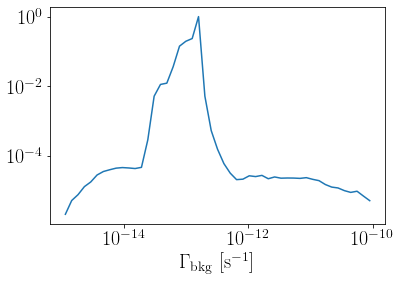

In [15]:
plt.plot((bine[1:]+bine[:-1])/2.,val/np.max(val))
plt.loglog()
plt.xlabel(r"$\Gamma_{\rm bkg} \ [\rm s^{-1}]$")

In [21]:
1/0.16-1

5.25

In [23]:
rootpath="/data/hqchen/mfp_project/data/"
folder="F_a0.1606_50pMpc/"
zuni=1/0.1606-1
Hz=cosmo.H(zuni).value


In [24]:
gammalist_z525=[]
dr_z525=[]
losList=glob.glob(rootpath+folder+"lightray*h5")
for losName in losList[:]:
    lr=yt.load(losName)
    los={}
    los["T"]=lr.r['temperature'].in_units("K").v
    los["nH"]=((lr.r['gas','RT_HVAR_HI']+lr.r['gas','RT_HVAR_HII'])/yt.units.mp).in_units("cm**-3").v
    los["nHe"]=((lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])/yt.units.mp/4).in_units("cm**-3").v
    los["xHI"]=lr.r['gas','RT_HVAR_HI']/(lr.r['gas','RT_HVAR_HI']+lr.r['gas','RT_HVAR_HII'])
    los["xHeI"]=lr.r['gas','RT_HVAR_HeI']/(lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])
    los["xHeII"]=lr.r['gas','RT_HVAR_HeII']/(lr.r['gas','RT_HVAR_HeI']+lr.r['gas','RT_HVAR_HeII']+lr.r['gas','RT_HVAR_HeIII'])
    gammalist_z525+=list(init_photo_bkg(los)[0][0])
    dr_z525+=list(lr.r['dl'].v)
#     plt.plot(init_photo_bkg(los)[0][0],alpha=0.1,c='b')
# # plt.yscale("log")
# plt.ylim(1e-13,2e-13)
# plt.grid()

yt : [INFO     ] 2024-02-06 16:11:41,775 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:11:41,776 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:11:41,777 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:11:41,778 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:11:41,779 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:11:41,779 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:11:41,780 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:11:41,780 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:11:41,781 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:11:41,781 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO   

yt : [INFO     ] 2024-02-06 16:11:46,361 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:11:46,362 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:11:46,363 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:11:46,364 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:11:46,365 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:11:46,366 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:11:46,366 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:11:46,367 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:11:46,368 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:11:46,381 Allocating for 6.544e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:11:50,447 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:11:50,448 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:11:50,448 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:11:50,449 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:11:50,449 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:11:50,450 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:11:50,450 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:11:50,451 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:11:50,457 Allocating for 5.316e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:11:50,465 Identified 3.697e+03 octs
yt : [INFO     ] 2024-02-06 16:11:

yt : [INFO     ] 2024-02-06 16:11:54,373 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:11:54,375 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:11:54,376 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:11:54,377 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:11:54,378 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:11:54,379 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:11:54,380 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:11:54,389 Allocating for 5.918e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:11:54,399 Identified 3.937e+03 octs
yt : [INFO     ] 2024-02-06 16:11:54,881 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:11:5

yt : [INFO     ] 2024-02-06 16:11:57,911 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:11:57,912 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:11:57,913 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:11:57,914 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:11:57,916 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:11:57,917 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:11:57,924 Allocating for 5.390e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:11:57,933 Identified 3.673e+03 octs
yt : [INFO     ] 2024-02-06 16:11:58,905 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:11:58,906 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:11:58,907 Parameters: dom

yt : [INFO     ] 2024-02-06 16:12:01,693 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:01,693 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:01,694 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:01,695 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:01,702 Allocating for 5.750e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:01,711 Identified 3.921e+03 octs
yt : [INFO     ] 2024-02-06 16:12:02,116 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:02,117 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:02,118 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:02,119 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:12:05,681 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:05,682 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:05,683 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:05,690 Allocating for 5.843e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:05,700 Identified 4.041e+03 octs
yt : [INFO     ] 2024-02-06 16:12:06,142 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:06,143 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:06,144 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:06,145 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:06,146 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:06,146 P

yt : [ERROR    ] 2024-02-06 16:12:09,692 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:09,692 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:09,700 Allocating for 5.988e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:09,719 Identified 4.009e+03 octs
yt : [INFO     ] 2024-02-06 16:12:10,151 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:10,152 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:10,153 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:10,153 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:10,154 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:10,154 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:10,155 P

yt : [INFO     ] 2024-02-06 16:12:12,838 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:12,844 Allocating for 6.148e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:12,853 Identified 3.825e+03 octs
yt : [INFO     ] 2024-02-06 16:12:13,720 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:13,721 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:13,722 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:13,722 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:13,723 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:13,724 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:13,725 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:13,

yt : [INFO     ] 2024-02-06 16:12:16,287 Allocating for 6.058e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:16,296 Identified 4.001e+03 octs
yt : [INFO     ] 2024-02-06 16:12:16,694 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:16,694 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:16,695 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:16,696 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:16,697 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:16,697 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:16,698 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:16,698 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:16,

yt : [INFO     ] 2024-02-06 16:12:19,759 Identified 4.033e+03 octs
yt : [INFO     ] 2024-02-06 16:12:20,159 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:20,160 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:20,161 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:20,162 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:20,163 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:20,163 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:20,164 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:20,165 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:20,165 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:20,166 Param

yt : [INFO     ] 2024-02-06 16:12:23,631 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:23,631 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:23,632 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:23,633 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:23,634 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:23,634 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:23,635 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:23,635 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:23,636 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:23,643 Allocating for 6.597e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:12:27,071 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:27,072 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:27,073 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:27,073 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:27,074 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:27,075 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:27,075 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:27,076 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:27,083 Allocating for 6.053e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:27,140 Identified 4.137e+03 octs
yt : [INFO     ] 2024-02-06 16:12:

yt : [INFO     ] 2024-02-06 16:12:30,097 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:30,098 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:30,098 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:30,099 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:30,100 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:30,100 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:30,101 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:30,107 Allocating for 7.040e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:30,131 Identified 4.601e+03 octs
yt : [INFO     ] 2024-02-06 16:12:30,518 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:3

yt : [INFO     ] 2024-02-06 16:12:33,497 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:33,498 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:33,498 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:33,499 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:33,499 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:33,500 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:33,508 Allocating for 5.652e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:33,516 Identified 3.745e+03 octs
yt : [INFO     ] 2024-02-06 16:12:33,921 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:33,922 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:33,923 Parameters: dom

yt : [INFO     ] 2024-02-06 16:12:36,867 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:36,867 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:36,868 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:36,869 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:36,876 Allocating for 4.643e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:36,891 Identified 3.265e+03 octs
yt : [INFO     ] 2024-02-06 16:12:37,298 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:37,299 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:37,299 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:37,300 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:12:40,001 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:40,001 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:40,002 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:40,010 Allocating for 6.999e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:40,019 Identified 4.665e+03 octs
yt : [INFO     ] 2024-02-06 16:12:41,073 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:41,074 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:41,075 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:41,075 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:41,076 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:41,077 P

yt : [ERROR    ] 2024-02-06 16:12:43,788 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:43,789 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:43,798 Allocating for 5.796e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:43,809 Identified 4.041e+03 octs
yt : [INFO     ] 2024-02-06 16:12:44,206 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:44,207 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:44,208 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:44,209 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:44,210 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:44,211 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:44,211 P

yt : [INFO     ] 2024-02-06 16:12:47,532 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:47,541 Allocating for 6.539e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:47,558 Identified 4.433e+03 octs
yt : [INFO     ] 2024-02-06 16:12:47,953 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:47,954 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:47,955 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:47,956 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:47,957 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:47,958 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:47,958 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:47,

yt : [INFO     ] 2024-02-06 16:12:51,538 Allocating for 6.936e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:12:51,555 Identified 4.609e+03 octs
yt : [INFO     ] 2024-02-06 16:12:51,995 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:51,996 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:51,997 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:51,998 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:51,999 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:51,999 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:52,000 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:52,001 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:52,

yt : [INFO     ] 2024-02-06 16:12:54,790 Identified 4.625e+03 octs
yt : [INFO     ] 2024-02-06 16:12:55,205 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:12:55,206 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:55,206 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:55,207 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:55,208 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:55,208 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:55,209 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:55,209 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:55,210 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:55,211 Param

yt : [INFO     ] 2024-02-06 16:12:58,922 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:12:58,923 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:12:58,923 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:12:58,924 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:12:58,925 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:12:58,925 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:12:58,926 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:12:58,926 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:12:58,927 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:12:58,933 Allocating for 7.332e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:13:02,790 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:02,791 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:02,792 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:02,793 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:02,794 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:02,794 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:02,795 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:02,796 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:02,807 Allocating for 5.737e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:02,829 Identified 3.737e+03 octs
yt : [INFO     ] 2024-02-06 16:13:

yt : [INFO     ] 2024-02-06 16:13:06,763 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:06,764 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:06,764 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:06,765 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:06,765 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:06,766 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:06,767 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:06,774 Allocating for 5.868e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:06,785 Identified 3.897e+03 octs
yt : [INFO     ] 2024-02-06 16:13:07,228 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:0

yt : [INFO     ] 2024-02-06 16:13:10,186 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:10,187 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:10,187 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:10,188 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:10,188 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:10,189 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:10,196 Allocating for 6.823e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:10,206 Identified 4.625e+03 octs
yt : [INFO     ] 2024-02-06 16:13:10,653 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:10,653 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:10,654 Parameters: dom

yt : [INFO     ] 2024-02-06 16:13:14,019 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:14,020 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:14,021 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:14,021 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:14,029 Allocating for 7.100e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:14,037 Identified 4.785e+03 octs
yt : [INFO     ] 2024-02-06 16:13:14,456 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:14,457 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:14,458 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:14,458 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:13:17,591 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:17,591 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:17,592 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:17,602 Allocating for 6.378e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:17,612 Identified 4.105e+03 octs
yt : [INFO     ] 2024-02-06 16:13:18,025 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:18,026 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:18,027 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:18,028 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:18,029 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:18,030 P

yt : [ERROR    ] 2024-02-06 16:13:20,634 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:20,635 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:20,642 Allocating for 6.701e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:20,651 Identified 4.553e+03 octs
yt : [INFO     ] 2024-02-06 16:13:21,784 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:21,785 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:21,786 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:21,787 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:21,788 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:21,788 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:21,789 P

yt : [INFO     ] 2024-02-06 16:13:24,655 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:24,662 Allocating for 6.889e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:24,672 Identified 4.409e+03 octs
yt : [INFO     ] 2024-02-06 16:13:25,124 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:25,125 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:25,126 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:25,127 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:25,128 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:25,129 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:25,130 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:25,

yt : [INFO     ] 2024-02-06 16:13:28,708 Allocating for 4.839e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:28,722 Identified 3.553e+03 octs
yt : [INFO     ] 2024-02-06 16:13:29,193 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:29,194 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:29,195 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:29,196 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:29,197 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:29,198 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:29,198 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:29,199 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:29,

yt : [INFO     ] 2024-02-06 16:13:32,394 Identified 4.297e+03 octs
yt : [INFO     ] 2024-02-06 16:13:32,807 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:32,808 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:32,808 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:32,809 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:32,810 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:32,811 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:32,811 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:32,812 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:32,812 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:32,813 Param

yt : [INFO     ] 2024-02-06 16:13:35,877 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:35,878 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:35,879 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:35,880 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:35,881 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:35,882 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:35,882 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:35,883 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:35,884 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:35,891 Allocating for 6.502e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:13:39,720 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:39,721 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:39,722 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:39,722 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:39,723 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:39,724 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:39,724 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:39,725 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:39,732 Allocating for 6.145e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:39,740 Identified 4.177e+03 octs
yt : [INFO     ] 2024-02-06 16:13:

yt : [INFO     ] 2024-02-06 16:13:43,171 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:43,172 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:43,173 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:43,173 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:43,174 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:43,175 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:43,175 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:43,186 Allocating for 6.393e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:43,195 Identified 4.273e+03 octs
yt : [INFO     ] 2024-02-06 16:13:43,615 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:4

yt : [INFO     ] 2024-02-06 16:13:46,286 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:46,287 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:46,288 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:46,289 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:46,289 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:46,290 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:46,297 Allocating for 4.405e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:46,305 Identified 2.673e+03 octs
yt : [INFO     ] 2024-02-06 16:13:47,417 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:47,418 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:47,419 Parameters: dom

yt : [INFO     ] 2024-02-06 16:13:50,003 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:13:50,003 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:50,004 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:50,004 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:50,010 Allocating for 5.076e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:50,019 Identified 3.457e+03 octs
yt : [INFO     ] 2024-02-06 16:13:50,412 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:50,413 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:50,414 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:50,414 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:13:53,866 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:13:53,867 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:53,868 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:53,875 Allocating for 4.996e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:53,884 Identified 3.513e+03 octs
yt : [INFO     ] 2024-02-06 16:13:54,286 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:54,287 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:54,288 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:54,289 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:54,289 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:54,290 P

yt : [ERROR    ] 2024-02-06 16:13:57,782 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:13:57,783 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:13:57,790 Allocating for 6.339e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:13:57,799 Identified 4.201e+03 octs
yt : [INFO     ] 2024-02-06 16:13:58,298 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:13:58,298 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:13:58,299 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:13:58,300 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:13:58,302 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:13:58,302 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:13:58,303 P

yt : [INFO     ] 2024-02-06 16:14:01,129 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:01,137 Allocating for 5.519e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:01,146 Identified 3.593e+03 octs
yt : [INFO     ] 2024-02-06 16:14:01,606 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:01,607 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:01,608 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:01,609 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:01,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:01,610 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:01,611 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:01,

yt : [INFO     ] 2024-02-06 16:14:05,205 Allocating for 6.850e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:05,214 Identified 4.865e+03 octs
yt : [INFO     ] 2024-02-06 16:14:05,649 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:05,650 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:05,651 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:05,651 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:05,652 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:05,652 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:05,653 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:05,653 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:05,

yt : [INFO     ] 2024-02-06 16:14:09,166 Identified 4.553e+03 octs
yt : [INFO     ] 2024-02-06 16:14:09,568 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:09,570 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:09,571 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:09,571 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:09,572 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:09,573 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:09,573 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:09,574 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:09,574 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:09,575 Param

yt : [INFO     ] 2024-02-06 16:14:12,561 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:12,561 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:12,562 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:12,563 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:12,563 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:12,564 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:12,564 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:12,565 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:12,565 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:12,572 Allocating for 6.082e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:14:16,384 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:16,385 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:16,385 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:16,386 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:16,387 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:16,387 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:16,388 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:16,388 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:16,395 Allocating for 5.621e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:16,444 Identified 3.849e+03 octs
yt : [INFO     ] 2024-02-06 16:14:

yt : [INFO     ] 2024-02-06 16:14:20,045 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:20,046 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:20,047 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:20,048 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:20,049 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:20,049 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:20,050 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:20,061 Allocating for 6.860e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:20,098 Identified 4.785e+03 octs
yt : [INFO     ] 2024-02-06 16:14:20,578 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:2

yt : [INFO     ] 2024-02-06 16:14:24,103 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:24,104 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:24,104 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:24,105 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:24,105 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:24,105 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:24,115 Allocating for 5.798e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:24,124 Identified 3.569e+03 octs
yt : [INFO     ] 2024-02-06 16:14:24,524 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:24,525 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:24,526 Parameters: dom

yt : [INFO     ] 2024-02-06 16:14:27,092 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:27,093 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:27,093 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:27,093 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:27,100 Allocating for 6.878e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:27,130 Identified 4.713e+03 octs
yt : [INFO     ] 2024-02-06 16:14:27,611 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:27,612 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:27,613 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:27,615 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:14:30,916 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:30,917 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:30,917 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:30,929 Allocating for 6.989e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:30,952 Identified 4.681e+03 octs
yt : [INFO     ] 2024-02-06 16:14:31,417 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:31,418 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:31,419 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:31,420 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:31,420 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:31,421 P

yt : [ERROR    ] 2024-02-06 16:14:35,085 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:35,085 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:35,098 Allocating for 6.901e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:35,112 Identified 4.849e+03 octs
yt : [INFO     ] 2024-02-06 16:14:35,546 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:35,547 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:35,548 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:35,549 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:35,549 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:35,550 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:35,551 P

yt : [INFO     ] 2024-02-06 16:14:38,453 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:38,465 Allocating for 6.244e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:38,476 Identified 4.313e+03 octs
yt : [INFO     ] 2024-02-06 16:14:38,926 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:38,927 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:38,928 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:38,929 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:38,930 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:38,931 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:38,932 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:38,

yt : [INFO     ] 2024-02-06 16:14:42,877 Allocating for 6.349e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:42,945 Identified 4.209e+03 octs
yt : [INFO     ] 2024-02-06 16:14:43,444 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:43,446 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:43,447 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:43,449 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:43,450 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:43,451 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:43,451 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:43,452 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:43,

yt : [INFO     ] 2024-02-06 16:14:47,446 Identified 3.569e+03 octs
yt : [INFO     ] 2024-02-06 16:14:48,024 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:48,025 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:48,026 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:48,027 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:48,028 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:48,029 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:48,030 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:48,031 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:48,031 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:48,032 Param

yt : [INFO     ] 2024-02-06 16:14:51,502 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:14:51,503 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:51,504 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:51,505 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:51,506 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:51,506 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:51,507 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:51,507 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:51,508 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:51,515 Allocating for 5.247e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:14:55,581 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:14:55,582 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:55,582 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:55,583 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:55,584 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:55,584 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:55,585 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:55,585 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:55,592 Allocating for 5.813e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:55,601 Identified 3.961e+03 octs
yt : [INFO     ] 2024-02-06 16:14:

yt : [INFO     ] 2024-02-06 16:14:59,444 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:14:59,445 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:14:59,446 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:14:59,446 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:14:59,447 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:14:59,447 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:14:59,448 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:14:59,455 Allocating for 6.231e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:14:59,464 Identified 4.289e+03 octs
yt : [INFO     ] 2024-02-06 16:14:59,871 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:14:5

yt : [INFO     ] 2024-02-06 16:15:02,544 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:02,544 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:02,545 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:02,545 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:02,546 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:02,546 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:02,554 Allocating for 5.940e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:02,563 Identified 4.169e+03 octs
yt : [INFO     ] 2024-02-06 16:15:02,986 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:02,987 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:02,987 Parameters: dom

yt : [INFO     ] 2024-02-06 16:15:06,665 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:06,665 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:06,666 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:06,666 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:06,674 Allocating for 6.843e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:06,684 Identified 4.537e+03 octs
yt : [INFO     ] 2024-02-06 16:15:07,168 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:07,169 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:07,170 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:07,171 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:15:10,729 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:10,729 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:10,730 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:10,737 Allocating for 6.628e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:10,747 Identified 4.641e+03 octs
yt : [INFO     ] 2024-02-06 16:15:11,188 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:11,189 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:11,190 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:11,191 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:11,192 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:11,192 P

yt : [ERROR    ] 2024-02-06 16:15:13,922 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:13,923 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:13,934 Allocating for 6.274e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:13,943 Identified 3.921e+03 octs
yt : [INFO     ] 2024-02-06 16:15:14,350 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:14,351 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:14,352 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:14,352 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:14,353 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:14,354 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:14,355 P

yt : [INFO     ] 2024-02-06 16:15:18,114 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:18,121 Allocating for 6.372e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:18,130 Identified 4.073e+03 octs
yt : [INFO     ] 2024-02-06 16:15:18,610 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:18,611 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:18,612 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:18,613 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:18,614 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:18,614 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:18,615 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:18,

yt : [INFO     ] 2024-02-06 16:15:22,570 Allocating for 6.177e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:22,583 Identified 4.281e+03 octs
yt : [INFO     ] 2024-02-06 16:15:23,062 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:23,063 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:23,064 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:23,064 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:23,065 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:23,066 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:23,066 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:23,067 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:23,

yt : [INFO     ] 2024-02-06 16:15:25,802 Identified 4.713e+03 octs
yt : [INFO     ] 2024-02-06 16:15:26,203 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:26,204 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:26,205 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:26,206 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:26,207 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:26,208 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:26,209 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:26,209 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:26,210 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:26,211 Param

yt : [INFO     ] 2024-02-06 16:15:29,964 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:29,965 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:29,966 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:29,967 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:29,968 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:29,969 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:29,969 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:29,970 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:29,971 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:29,980 Allocating for 5.516e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:15:33,933 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:33,934 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:33,935 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:33,936 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:33,937 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:33,937 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:33,938 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:33,940 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:33,950 Allocating for 6.167e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:33,963 Identified 4.065e+03 octs
yt : [INFO     ] 2024-02-06 16:15:

yt : [INFO     ] 2024-02-06 16:15:37,197 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:37,198 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:37,199 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:37,200 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:37,201 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:37,201 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:37,202 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:37,209 Allocating for 6.175e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:37,218 Identified 4.073e+03 octs
yt : [INFO     ] 2024-02-06 16:15:37,651 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:3

yt : [INFO     ] 2024-02-06 16:15:41,173 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:41,173 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:41,174 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:41,175 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:41,176 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:41,176 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:41,183 Allocating for 6.926e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:41,191 Identified 4.785e+03 octs
yt : [INFO     ] 2024-02-06 16:15:41,597 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:41,599 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:41,600 Parameters: dom

yt : [INFO     ] 2024-02-06 16:15:44,892 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:44,893 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:44,893 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:44,894 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:44,901 Allocating for 6.867e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:44,911 Identified 4.849e+03 octs
yt : [INFO     ] 2024-02-06 16:15:45,331 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:45,332 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:45,333 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:45,334 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:15:47,917 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:47,918 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:47,919 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:47,926 Allocating for 6.156e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:47,934 Identified 4.193e+03 octs
yt : [INFO     ] 2024-02-06 16:15:48,331 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:48,332 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:48,333 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:48,333 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:48,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:48,335 P

yt : [ERROR    ] 2024-02-06 16:15:51,682 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:15:51,683 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:51,689 Allocating for 5.564e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:51,698 Identified 3.745e+03 octs
yt : [INFO     ] 2024-02-06 16:15:52,113 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:52,114 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:52,115 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:52,116 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:52,117 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:52,117 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:52,118 P

yt : [INFO     ] 2024-02-06 16:15:55,267 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:15:55,274 Allocating for 7.290e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:55,283 Identified 5.201e+03 octs
yt : [INFO     ] 2024-02-06 16:15:55,681 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:55,682 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:55,683 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:55,684 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:55,685 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:55,686 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:55,686 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:55,

yt : [INFO     ] 2024-02-06 16:15:58,271 Allocating for 6.080e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:15:58,281 Identified 4.305e+03 octs
yt : [INFO     ] 2024-02-06 16:15:58,665 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:15:58,665 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:15:58,666 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:15:58,667 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:15:58,668 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:15:58,669 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:15:58,669 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:15:58,670 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:15:58,

yt : [INFO     ] 2024-02-06 16:16:01,899 Identified 3.617e+03 octs
yt : [INFO     ] 2024-02-06 16:16:02,309 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:02,310 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:02,311 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:02,312 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:02,313 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:02,313 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:02,314 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:02,315 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:02,315 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:02,316 Param

yt : [INFO     ] 2024-02-06 16:16:05,921 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:05,922 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:05,923 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:05,924 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:05,924 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:05,925 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:05,926 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:05,926 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:05,927 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:05,934 Allocating for 6.518e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:16:09,150 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:09,150 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:09,151 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:09,151 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:09,152 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:09,152 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:09,152 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:09,153 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:09,159 Allocating for 6.296e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:09,168 Identified 4.265e+03 octs
yt : [INFO     ] 2024-02-06 16:16:

yt : [INFO     ] 2024-02-06 16:16:12,801 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:12,801 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:12,802 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:12,802 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:12,802 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:12,803 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:12,803 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:12,810 Allocating for 7.009e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:12,819 Identified 4.729e+03 octs
yt : [INFO     ] 2024-02-06 16:16:13,227 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:1

yt : [INFO     ] 2024-02-06 16:16:16,701 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:16,702 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:16,703 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:16,703 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:16,704 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:16,704 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:16,712 Allocating for 6.425e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:16,722 Identified 4.449e+03 octs
yt : [INFO     ] 2024-02-06 16:16:17,201 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:17,202 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:17,202 Parameters: dom

yt : [INFO     ] 2024-02-06 16:16:20,095 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:20,096 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:20,097 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:20,097 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:20,098 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:20,098 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:20,099 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:20,105 Allocating for 6.052e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:20,114 Identified 4.025e+03 octs
yt : [INFO     ] 2024-02-06 16:16:20,508 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:2

yt : [INFO     ] 2024-02-06 16:16:24,306 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:24,307 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:24,307 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:24,308 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:24,308 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:24,309 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:24,316 Allocating for 5.925e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:24,325 Identified 4.089e+03 octs
yt : [INFO     ] 2024-02-06 16:16:24,736 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:24,737 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:24,738 Parameters: dom

yt : [INFO     ] 2024-02-06 16:16:27,735 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:27,735 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:27,736 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:27,737 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:27,743 Allocating for 4.566e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:27,751 Identified 3.201e+03 octs
yt : [INFO     ] 2024-02-06 16:16:29,264 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:29,265 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:29,266 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:29,267 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:16:32,320 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:32,320 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:32,321 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:32,328 Allocating for 4.987e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:32,337 Identified 3.417e+03 octs
yt : [INFO     ] 2024-02-06 16:16:32,765 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:32,766 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:32,767 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:32,768 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:32,769 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:32,770 P

yt : [ERROR    ] 2024-02-06 16:16:36,727 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:36,728 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:36,736 Allocating for 6.819e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:36,746 Identified 4.473e+03 octs
yt : [INFO     ] 2024-02-06 16:16:37,208 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:37,210 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:37,211 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:37,212 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:37,213 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:37,214 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:37,214 P

yt : [INFO     ] 2024-02-06 16:16:40,410 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:40,418 Allocating for 5.717e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:40,427 Identified 3.849e+03 octs
yt : [INFO     ] 2024-02-06 16:16:40,936 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:40,937 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:40,938 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:40,939 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:40,940 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:40,941 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:40,941 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:40,

yt : [INFO     ] 2024-02-06 16:16:44,786 Allocating for 6.664e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:44,815 Identified 4.721e+03 octs
yt : [INFO     ] 2024-02-06 16:16:45,240 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:45,241 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:45,242 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:45,243 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:45,244 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:45,245 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:45,246 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:45,246 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:45,

yt : [INFO     ] 2024-02-06 16:16:48,834 Identified 4.009e+03 octs
yt : [INFO     ] 2024-02-06 16:16:49,265 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:16:49,266 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:49,267 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:49,268 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:49,269 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:49,270 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:49,270 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:49,271 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:49,272 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:49,272 Param

yt : [INFO     ] 2024-02-06 16:16:52,456 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:16:52,457 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:52,458 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:52,459 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:52,460 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:52,461 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:52,462 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:52,462 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:52,463 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:52,471 Allocating for 7.037e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:16:56,591 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:16:56,592 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:16:56,593 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:16:56,594 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:16:56,594 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:16:56,595 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:16:56,596 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:16:56,596 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:16:56,605 Allocating for 6.412e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:16:56,614 Identified 4.209e+03 octs
yt : [INFO     ] 2024-02-06 16:16:

yt : [INFO     ] 2024-02-06 16:17:00,483 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:00,484 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:00,484 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:00,485 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:00,486 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:00,486 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:00,487 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:00,495 Allocating for 6.804e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:00,520 Identified 4.673e+03 octs
yt : [INFO     ] 2024-02-06 16:17:00,979 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:0

yt : [INFO     ] 2024-02-06 16:17:03,877 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:03,878 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:03,879 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:03,880 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:03,881 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:03,881 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:03,890 Allocating for 6.918e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:03,906 Identified 4.657e+03 octs
yt : [INFO     ] 2024-02-06 16:17:04,379 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:04,380 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:04,381 Parameters: dom

yt : [INFO     ] 2024-02-06 16:17:08,230 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:08,230 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:08,231 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:08,232 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:08,239 Allocating for 6.857e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:08,249 Identified 4.585e+03 octs
yt : [INFO     ] 2024-02-06 16:17:08,657 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:08,658 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:08,659 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:08,660 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:17:11,966 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:11,966 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:11,967 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:11,975 Allocating for 7.275e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:11,984 Identified 4.913e+03 octs
yt : [INFO     ] 2024-02-06 16:17:12,398 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:12,398 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:12,399 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:12,400 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:12,401 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:12,402 P

yt : [ERROR    ] 2024-02-06 16:17:15,421 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:15,422 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:15,430 Allocating for 6.548e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:15,439 Identified 4.481e+03 octs
yt : [INFO     ] 2024-02-06 16:17:15,856 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:15,857 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:15,858 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:15,859 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:15,860 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:15,860 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:15,861 P

yt : [INFO     ] 2024-02-06 16:17:19,706 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:19,718 Allocating for 6.068e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:19,729 Identified 4.249e+03 octs
yt : [INFO     ] 2024-02-06 16:17:20,197 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:20,197 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:20,198 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:20,199 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:20,200 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:20,201 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:20,202 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:20,

yt : [INFO     ] 2024-02-06 16:17:22,963 Allocating for 6.373e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:22,972 Identified 4.153e+03 octs
yt : [INFO     ] 2024-02-06 16:17:23,386 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:23,387 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:23,388 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:23,389 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:23,389 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:23,390 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:23,391 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:23,391 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:23,

yt : [INFO     ] 2024-02-06 16:17:27,057 Identified 4.921e+03 octs
yt : [INFO     ] 2024-02-06 16:17:27,482 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:27,482 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:27,483 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:27,484 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:27,484 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:27,485 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:27,485 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:27,486 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:27,486 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:27,487 Param

yt : [INFO     ] 2024-02-06 16:17:31,819 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:31,820 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:31,821 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:31,822 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:31,823 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:31,823 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:31,824 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:31,825 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:31,826 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:31,834 Allocating for 5.516e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:17:35,195 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:35,196 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:35,197 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:35,197 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:35,198 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:35,198 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:35,198 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:35,199 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:35,207 Allocating for 5.848e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:35,260 Identified 4.065e+03 octs
yt : [INFO     ] 2024-02-06 16:17:

yt : [INFO     ] 2024-02-06 16:17:39,401 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:39,402 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:39,402 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:39,403 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:39,403 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:39,404 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:39,404 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:39,412 Allocating for 6.614e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:39,422 Identified 4.513e+03 octs
yt : [INFO     ] 2024-02-06 16:17:39,906 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:3

yt : [INFO     ] 2024-02-06 16:17:42,904 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:42,904 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:42,905 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:42,905 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:42,906 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:42,906 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:42,914 Allocating for 6.268e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:42,948 Identified 4.097e+03 octs
yt : [INFO     ] 2024-02-06 16:17:44,244 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:44,245 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:44,246 Parameters: dom

yt : [INFO     ] 2024-02-06 16:17:47,164 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:47,165 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:47,166 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:47,166 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:47,176 Allocating for 6.746e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:47,208 Identified 4.593e+03 octs
yt : [INFO     ] 2024-02-06 16:17:47,649 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:47,650 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:47,651 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:47,652 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:17:51,473 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:17:51,474 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:51,474 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:51,482 Allocating for 7.072e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:51,498 Identified 4.921e+03 octs
yt : [INFO     ] 2024-02-06 16:17:51,966 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:51,967 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:51,968 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:51,969 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:51,970 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:51,970 P

yt : [ERROR    ] 2024-02-06 16:17:54,711 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:17:54,711 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:54,722 Allocating for 6.407e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:54,780 Identified 4.585e+03 octs
yt : [INFO     ] 2024-02-06 16:17:55,248 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:55,248 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:55,249 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:55,250 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:55,251 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:55,251 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:55,252 P

yt : [INFO     ] 2024-02-06 16:17:58,634 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:17:58,642 Allocating for 6.724e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:17:58,651 Identified 4.633e+03 octs
yt : [INFO     ] 2024-02-06 16:17:59,048 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:17:59,049 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:17:59,050 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:17:59,051 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:17:59,052 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:17:59,052 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:17:59,053 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:17:59,

yt : [INFO     ] 2024-02-06 16:18:02,280 Allocating for 6.211e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:02,289 Identified 3.929e+03 octs
yt : [INFO     ] 2024-02-06 16:18:02,713 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:02,714 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:02,715 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:02,716 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:02,717 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:02,718 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:02,718 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:02,719 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:02,

yt : [INFO     ] 2024-02-06 16:18:05,374 Identified 4.145e+03 octs
yt : [INFO     ] 2024-02-06 16:18:05,778 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:05,779 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:05,780 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:05,781 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:05,781 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:05,782 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:05,783 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:05,783 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:05,784 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:05,785 Param

yt : [INFO     ] 2024-02-06 16:18:09,655 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:09,655 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:09,656 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:09,657 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:09,658 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:09,659 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:09,659 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:09,660 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:09,660 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:09,667 Allocating for 7.137e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:18:12,761 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:12,762 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:12,763 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:12,764 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:12,764 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:12,765 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:12,766 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:12,766 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:12,774 Allocating for 6.163e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:12,782 Identified 4.145e+03 octs
yt : [INFO     ] 2024-02-06 16:18:

yt : [INFO     ] 2024-02-06 16:18:16,824 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:16,825 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:16,826 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:16,826 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:16,827 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:16,828 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:16,829 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:16,838 Allocating for 5.695e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:16,848 Identified 4.017e+03 octs
yt : [INFO     ] 2024-02-06 16:18:17,271 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:1

yt : [INFO     ] 2024-02-06 16:18:20,981 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:20,982 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:20,983 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:20,985 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:20,986 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:20,987 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:20,995 Allocating for 7.040e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:21,005 Identified 4.993e+03 octs
yt : [INFO     ] 2024-02-06 16:18:21,437 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:21,438 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:21,439 Parameters: dom

yt : [INFO     ] 2024-02-06 16:18:24,224 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:24,225 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:24,226 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:24,226 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:24,233 Allocating for 5.382e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:24,241 Identified 3.609e+03 octs
yt : [INFO     ] 2024-02-06 16:18:24,635 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:24,636 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:24,636 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:24,638 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:18:28,454 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:28,455 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:28,455 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:28,463 Allocating for 7.649e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:28,473 Identified 5.145e+03 octs
yt : [INFO     ] 2024-02-06 16:18:28,910 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:28,911 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:28,912 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:28,913 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:28,914 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:28,914 P

yt : [ERROR    ] 2024-02-06 16:18:31,637 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:31,638 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:31,645 Allocating for 6.824e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:31,654 Identified 4.657e+03 octs
yt : [INFO     ] 2024-02-06 16:18:32,144 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:32,144 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:32,146 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:32,147 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:32,148 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:32,148 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:32,149 P

yt : [INFO     ] 2024-02-06 16:18:35,703 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:35,710 Allocating for 4.227e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:35,732 Identified 2.665e+03 octs
yt : [INFO     ] 2024-02-06 16:18:36,145 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:36,146 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:36,147 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:36,148 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:36,149 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:36,150 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:36,150 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:36,

yt : [INFO     ] 2024-02-06 16:18:39,595 Allocating for 5.903e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:39,604 Identified 3.633e+03 octs
yt : [INFO     ] 2024-02-06 16:18:40,010 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:40,012 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:40,013 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:40,014 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:40,015 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:40,016 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:40,016 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:40,017 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:40,

yt : [INFO     ] 2024-02-06 16:18:42,604 Identified 3.929e+03 octs
yt : [INFO     ] 2024-02-06 16:18:43,009 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:43,010 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:43,011 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:43,012 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:43,012 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:43,013 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:43,014 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:43,014 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:43,015 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:43,016 Param

yt : [INFO     ] 2024-02-06 16:18:47,064 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:47,065 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:47,066 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:47,066 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:47,067 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:47,068 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:47,069 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:47,069 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:47,070 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:47,079 Allocating for 5.282e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:18:50,052 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:18:50,053 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:50,054 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:50,055 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:50,055 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:50,056 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:50,057 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:50,057 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:50,064 Allocating for 6.876e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:50,072 Identified 4.881e+03 octs
yt : [INFO     ] 2024-02-06 16:18:

yt : [INFO     ] 2024-02-06 16:18:54,221 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:18:54,222 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:54,222 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:54,223 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:54,223 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:54,224 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:54,224 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:54,231 Allocating for 6.849e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:54,239 Identified 4.737e+03 octs
yt : [INFO     ] 2024-02-06 16:18:54,654 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:5

yt : [INFO     ] 2024-02-06 16:18:58,287 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:18:58,288 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:18:58,288 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:18:58,289 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:18:58,290 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:18:58,290 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:18:58,299 Allocating for 6.650e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:18:58,313 Identified 4.425e+03 octs
yt : [INFO     ] 2024-02-06 16:18:58,750 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:18:58,751 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:18:58,751 Parameters: dom

yt : [INFO     ] 2024-02-06 16:19:01,334 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:01,334 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:01,335 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:01,336 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:01,342 Allocating for 6.135e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:01,350 Identified 4.233e+03 octs
yt : [INFO     ] 2024-02-06 16:19:01,736 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:01,737 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:01,738 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:01,738 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:19:05,220 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:05,221 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:05,221 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:05,228 Allocating for 6.121e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:05,238 Identified 4.161e+03 octs
yt : [INFO     ] 2024-02-06 16:19:05,650 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:05,651 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:05,651 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:05,652 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:05,653 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:05,653 P

yt : [ERROR    ] 2024-02-06 16:19:08,176 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:08,177 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:08,183 Allocating for 5.406e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:08,191 Identified 3.857e+03 octs
yt : [INFO     ] 2024-02-06 16:19:08,592 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:08,593 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:08,593 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:08,594 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:08,595 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:08,596 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:08,596 P

yt : [INFO     ] 2024-02-06 16:19:12,077 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:12,087 Allocating for 7.064e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:12,097 Identified 4.785e+03 octs
yt : [INFO     ] 2024-02-06 16:19:12,497 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:12,498 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:12,499 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:12,500 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:12,501 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:12,502 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:12,503 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:12,

yt : [INFO     ] 2024-02-06 16:19:16,087 Allocating for 7.273e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:16,097 Identified 5.049e+03 octs
yt : [INFO     ] 2024-02-06 16:19:16,542 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:16,543 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:16,543 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:16,545 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:16,545 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:16,546 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:16,547 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:16,548 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:16,

yt : [INFO     ] 2024-02-06 16:19:19,523 Identified 3.737e+03 octs
yt : [INFO     ] 2024-02-06 16:19:19,910 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:19,911 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:19,912 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:19,913 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:19,913 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:19,914 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:19,915 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:19,915 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:19,916 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:19,917 Param

yt : [INFO     ] 2024-02-06 16:19:24,122 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:24,123 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:24,124 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:24,125 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:24,126 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:24,126 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:24,127 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:24,128 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:24,128 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:24,136 Allocating for 6.488e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:19:27,557 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:27,558 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:27,559 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:27,560 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:27,560 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:27,561 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:27,562 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:27,562 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:27,570 Allocating for 5.386e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:27,579 Identified 3.673e+03 octs
yt : [INFO     ] 2024-02-06 16:19:

yt : [INFO     ] 2024-02-06 16:19:31,588 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:31,589 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:31,590 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:31,590 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:31,591 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:31,592 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:31,592 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:31,599 Allocating for 5.952e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:31,608 Identified 4.185e+03 octs
yt : [INFO     ] 2024-02-06 16:19:32,085 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:3

yt : [INFO     ] 2024-02-06 16:19:35,010 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:35,011 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:35,012 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:35,013 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:35,013 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:35,014 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:35,026 Allocating for 5.935e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:35,038 Identified 4.177e+03 octs
yt : [INFO     ] 2024-02-06 16:19:36,170 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:36,172 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:36,173 Parameters: dom

yt : [INFO     ] 2024-02-06 16:19:39,195 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:39,196 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:39,196 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:39,197 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:39,205 Allocating for 6.509e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:39,214 Identified 4.433e+03 octs
yt : [INFO     ] 2024-02-06 16:19:39,631 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:39,632 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:39,633 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:39,634 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:19:42,893 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:42,894 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:42,895 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:42,902 Allocating for 6.095e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:42,912 Identified 3.881e+03 octs
yt : [INFO     ] 2024-02-06 16:19:43,342 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:43,344 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:43,344 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:43,345 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:43,346 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:43,347 P

yt : [ERROR    ] 2024-02-06 16:19:46,157 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:46,158 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:46,165 Allocating for 5.718e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:46,174 Identified 3.745e+03 octs
yt : [INFO     ] 2024-02-06 16:19:46,604 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:46,605 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:46,606 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:46,607 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:46,608 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:46,608 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:46,609 P

yt : [INFO     ] 2024-02-06 16:19:49,965 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:19:49,972 Allocating for 5.356e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:49,981 Identified 3.793e+03 octs
yt : [INFO     ] 2024-02-06 16:19:50,441 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:50,442 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:50,443 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:50,445 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:50,446 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:50,446 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:50,447 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:50,

yt : [INFO     ] 2024-02-06 16:19:53,248 Allocating for 6.632e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:19:53,260 Identified 4.337e+03 octs
yt : [INFO     ] 2024-02-06 16:19:53,687 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:53,688 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:53,689 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:53,690 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:53,691 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:53,691 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:53,692 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:53,692 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:53,

yt : [INFO     ] 2024-02-06 16:19:57,041 Identified 4.713e+03 octs
yt : [INFO     ] 2024-02-06 16:19:57,516 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:19:57,517 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:19:57,518 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:19:57,519 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:19:57,520 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:19:57,521 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:19:57,522 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:19:57,522 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:19:57,523 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:19:57,524 Param

yt : [INFO     ] 2024-02-06 16:20:00,532 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:20:00,533 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:20:00,534 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:20:00,535 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:20:00,536 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:20:00,537 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:20:00,538 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:20:00,538 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:20:00,539 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:00,548 Allocating for 5.588e+03 particles (index particle type 'all')
yt : [INFO  

yt : [INFO     ] 2024-02-06 16:20:04,689 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:20:04,690 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:20:04,691 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:20:04,692 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:20:04,694 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:20:04,695 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:20:04,696 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:20:04,697 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:04,705 Allocating for 5.905e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:20:04,715 Identified 4.073e+03 octs
yt : [INFO     ] 2024-02-06 16:20:

yt : [INFO     ] 2024-02-06 16:20:08,793 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:20:08,794 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:20:08,795 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:20:08,796 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:20:08,796 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:20:08,797 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:20:08,798 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:08,808 Allocating for 6.800e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:20:08,836 Identified 4.697e+03 octs
yt : [INFO     ] 2024-02-06 16:20:09,315 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:20:0

yt : [INFO     ] 2024-02-06 16:20:12,050 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:20:12,051 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:20:12,051 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:20:12,052 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:20:12,052 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:20:12,053 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:12,060 Allocating for 6.318e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:20:12,071 Identified 4.113e+03 octs
yt : [INFO     ] 2024-02-06 16:20:12,462 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:20:12,463 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:20:12,464 Parameters: dom

yt : [INFO     ] 2024-02-06 16:20:16,234 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:20:16,235 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:20:16,235 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:20:16,236 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:16,250 Allocating for 6.858e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:20:16,264 Identified 4.993e+03 octs
yt : [INFO     ] 2024-02-06 16:20:16,812 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:20:16,813 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:20:16,814 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:20:16,815 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 

yt : [INFO     ] 2024-02-06 16:20:19,476 Parameters: omega_matter              = 0.3035999834537506
yt : [ERROR    ] 2024-02-06 16:20:19,477 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:20:19,477 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:19,484 Allocating for 5.356e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:20:19,492 Identified 3.745e+03 octs
yt : [INFO     ] 2024-02-06 16:20:19,986 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:20:19,988 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:20:19,989 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:20:19,990 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:20:19,990 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:20:19,991 P

yt : [ERROR    ] 2024-02-06 16:20:24,008 Missing omega_radiation in parameter file definition!
yt : [INFO     ] 2024-02-06 16:20:24,009 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:24,016 Allocating for 5.540e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:20:24,025 Identified 3.897e+03 octs
yt : [INFO     ] 2024-02-06 16:20:24,558 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:20:24,559 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:20:24,560 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:20:24,561 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:20:24,562 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:20:24,563 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:20:24,564 P

yt : [INFO     ] 2024-02-06 16:20:27,282 Parameters: hubble_constant           = 0.6814000010490417
yt : [INFO     ] 2024-02-06 16:20:27,288 Allocating for 5.858e+03 particles (index particle type 'all')
yt : [INFO     ] 2024-02-06 16:20:27,297 Identified 4.001e+03 octs
yt : [INFO     ] 2024-02-06 16:20:27,802 Parameters: current_time              = 1112947967.7900774 yr
yt : [INFO     ] 2024-02-06 16:20:27,803 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2024-02-06 16:20:27,804 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-02-06 16:20:27,805 Parameters: domain_right_edge         = [256. 256. 256.] code_length
yt : [INFO     ] 2024-02-06 16:20:27,806 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-06 16:20:27,807 Parameters: current_redshift          = 5.2259847855641555
yt : [INFO     ] 2024-02-06 16:20:27,808 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2024-02-06 16:20:27,

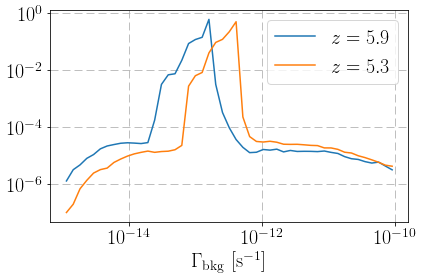

In [29]:
val_z525,bine_z525=np.histogram(gammalist_z525,bins=np.logspace(-15,-10),weights=dr_z525)
plt.plot((bine[1:]+bine[:-1])/2.,val/np.sum(val),label=r"$z=5.9$")
plt.plot((bine_z525[1:]+bine_z525[:-1])/2.,val_z525/np.sum(val_z525),label=r"$z=5.3$")
plt.loglog()
plt.legend()
plt.xlabel(r"$\Gamma_{\rm bkg} \ [\rm s^{-1}]$")
plt.tight_layout()
plt.grid(dashes=(10,5))
plt.savefig("Gamma_scatter_evolution.pdf")